# Setup

In [1]:
# Import packages
import os
import re
import string
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tf.__version__ # 2.x

'2.3.0'

In [2]:
# Globals
BUFFER_SIZE = 5000
BUFFER_BATCH_SIZE = 64
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256
EMBEDDING_DIM = 100

embeddings_dir = "/home/nityan/embeddings/"

# Using word embeddings

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction).
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve.
These are called "pre-trained word embeddings".

## Learning word embeddings with the Embedding layer

The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

In [3]:
dataset, info = tfds.load(name = "imdb_reviews", with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset["train"], dataset["test"]
print(train_dataset.element_spec, test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)) (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [4]:
# View some examples from train
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [5]:
# View some examples from test
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
Label: tf.Tens

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b"I must say, this movie has given me a dual personality. I've been told again and again to SHUT UP and start speaking like a normal person. But, it's very hard... no not the wang. Did you find that disgusting and disrespectful? Well, get in the mood for a lot more. This movie is just filthy! It's not a film to show your grand-parents, but you should show it to a teenager or some immature guy at your workplace. Anyway, back to the voice mannerisms. Fortunately this site has some Ladies Man (did anyone at the studio notice that there's supposed to be a apostrophe(?) between the e and s?) so you can always have a fine little something to say to your boss or the cops. I have a sheet in my wallet.", shape=(), dtype=string)


## Data processing

In [8]:
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML).
# We will need to create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [9]:
encoder = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = custom_standardization,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = MAX_SEQUENCE_LENGTH
)

# Adapt to train text
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b'The case is the best part of the movie but it alone is not worth the purchase price. I expected a "Based on the true story" movie only to find a shot on home video hodge-podge of poorly shot clips tied together with pathetic acting and non-related slaughter house scenes. The video scenes had numerous rewind situations which were used probably to extend the length of the feature rather than for effects. I started this review before I was even halfway through the movie and waited till it was over just in case it had a better ending but, low and behold it only got worse. If I could mark it any lower it would have been a negative ten. Learn from my mistake and save your money and time with this one.', shape=(), dtype=string)


In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return encoder(text), label

# Vectorize the data.
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

In [12]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(
[  10   40  209   11   19   20  290  227  310    3  837    6  802   45
    2  825   11 1913    9  180   12   10 2382   43    1    2 2777  808
 1782  128   20  939    3  336 2181    6    4  169    5 6192    3    1
   98   10  161   11  623 1698   14   11   19    7   21   84   41   53
   49   18 1047    7    9  380   41   53   62   80   48   11   19   62
    7    1 2201   12    2  167    1 3871    7   37 1586    6 9862   56
 5470 2630    1    3 8164   93   14 2054  155  484   11   19   14    1
  415   31  125    9   35    2  112  360   33 7921 1484    5    1    3
 8700    1    6 7808  107    4    1    1   16    4    1    5    1    6
    2  309  301   12 4881   35 2593    3    4  163  371   10 2382    7
 1018  176  841    2  393  215   17   15 1660  305 3847  112    1 9385
  776    3  748    3  748    5    1 1247    7 1475   18   71  446  679
   12   27  180    6   26 3995 2421 9773  568    6  963    4  325 1441
 4530    2   63   43  748    5 1525    8    9    5   31    1   18 

## Modelling

In [13]:
model = tf.keras.Sequential()

# Embedding layer: max_features/vocab size, embedding size
model.add(layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(layers.Flatten())

# Adding hidden layers
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))

# We add the classifier on top
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1638464   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,640,577
Trainable params: 2,640,577
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Create a model loss tracker for early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
]

In [15]:
# Train and validate model
history = model.fit(
    train_dataset,
    epochs=10,
    batch_size=32,
    validation_data=test_dataset,
    callbacks=callbacks)

Epoch 1/10
391/391 [==============================] - 7s 17ms/step - loss: 0.4587 - accuracy: 0.7640 - val_loss: 0.3296 - val_accuracy: 0.8563
Epoch 2/10
391/391 [==============================] - 6s 16ms/step - loss: 0.1285 - accuracy: 0.9509 - val_loss: 0.4948 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 6s 17ms/step - loss: 0.0173 - accuracy: 0.9943 - val_loss: 0.9457 - val_accuracy: 0.8074
Epoch 4/10
391/391 [==============================] - 6s 17ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 1.2945 - val_accuracy: 0.8110


In [16]:
# Evaluate model performance on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print("Test loss;", test_loss)
print("Test accuracy:", test_acc)

391/391 [==============================] - 2s 6ms/step - loss: 1.2945 - accuracy: 0.8110
Test loss; 1.2944830656051636
Test accuracy: 0.8109599947929382


## Visualize model performance

In [17]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

(0.0, 1.3590729106450454)

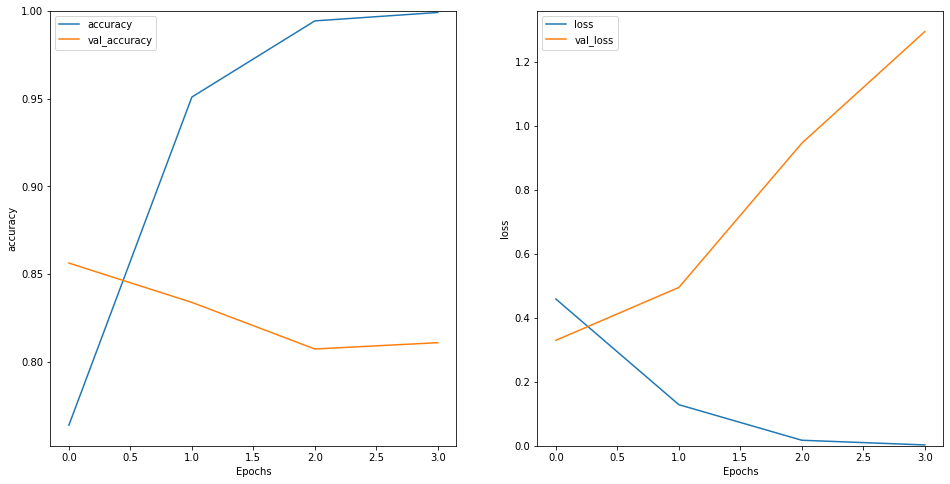

In [18]:
# Create a figure
plt.figure(figsize=(16,8))

# Plot accuracy graph
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None,1)

# Plot loss graph
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

# Using pre-trained embeddings

Download the GloVe word embeddings

Head to `https://nlp.stanford.edu/projects/glove/`, and download a pre-computed 
embeddings.

In [19]:
# Get vocab for the corpus
vocabulary = encoder.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

print("Total number of words:", len(word_index))

Total number of words: 10000


## Pre-process embeddings

In [20]:
embeddings_index = dict()
with open(os.path.join(embeddings_dir, "glove.6B.100d.txt")) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer.

In [21]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM)) # Embeddingg dimension of the pre-trained embedding = 100

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i <= VOCAB_SIZE:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
print("Embedding Matrix:", embedding_matrix.shape)

Embedding Matrix: (10000, 100)


## Modelling

In [22]:
model = tf.keras.Sequential()

# Load pre-trained embedding matric into the `Embedding` layer
# Make this layer static
model.add(layers.Embedding(
    VOCAB_SIZE,
    EMBEDDING_DIM,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    input_length=MAX_SEQUENCE_LENGTH))

model.add(layers.Flatten())

# Adding hidden layers
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))

# We add the classifier on top
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1638464   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,640,577
Trainable params: 1,640,577
Non-trainable params: 1,000,000
_________________________________________________________________


In [23]:
# Train and validate model
history = model.fit(
    train_dataset,
    epochs=10,
    batch_size=32,
    validation_data=test_dataset,
    callbacks=callbacks)

# Save weights
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
391/391 [==============================] - 5s 12ms/step - loss: 0.6960 - accuracy: 0.6208 - val_loss: 0.5668 - val_accuracy: 0.7162
Epoch 2/10
391/391 [==============================] - 5s 12ms/step - loss: 0.5258 - accuracy: 0.7405 - val_loss: 0.6736 - val_accuracy: 0.6499
Epoch 3/10
391/391 [==============================] - 5s 13ms/step - loss: 0.4416 - accuracy: 0.7934 - val_loss: 0.6471 - val_accuracy: 0.6808
Epoch 4/10
391/391 [==============================] - 5s 12ms/step - loss: 0.3741 - accuracy: 0.8289 - val_loss: 0.6054 - val_accuracy: 0.7280


(0.0, 0.7120960965752602)

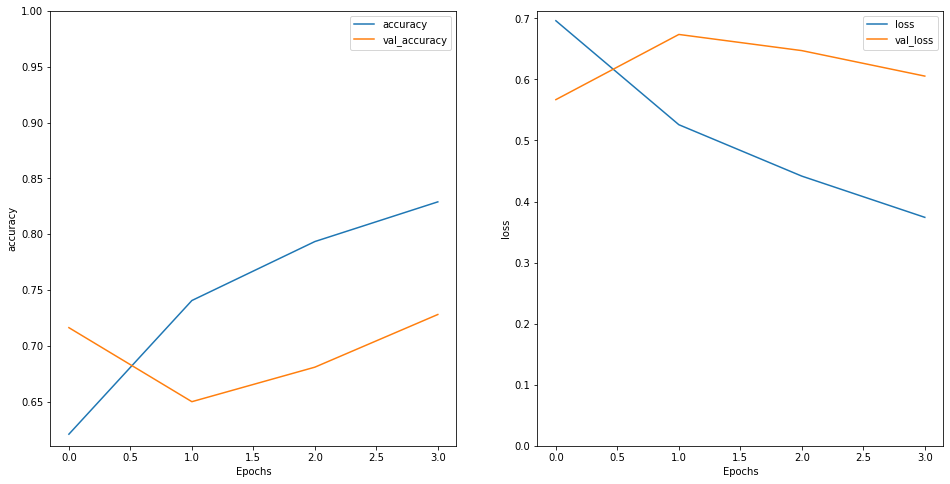

In [24]:
# Create a figure
plt.figure(figsize=(16,8))

# Plot accuracy graph
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None,1)

# Plot loss graph
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)